In [34]:
import os, sys, torch, argparse, re, mat73, scipy, time
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import neurokit2 as nk
import peakutils
from copy import deepcopy
import pandas as pd
from scipy.signal import find_peaks
sys.path.append('/home/zhangyuanyuan/CFT-RFcardi/RFcardi_Transfer_Learning/') # append your project path
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from LibMTL.config import LibMTL_args, prepare_args
from LibMTL.utils import set_random_seed, set_device
from LibMTL.model import resnet_dilated
from LibMTL import Trainer
from Projects.radarODE_transfer.utils.utils import shapeMetric, shapeLoss, ppiMetric, ppiLoss, anchorMetric, anchorLoss
from Projects.radarODE_transfer.nets.PPI_decoder import PPI_decoder
from Projects.radarODE_transfer.nets.anchor_decoder import anchor_decoder
from Projects.radarODE_transfer.nets.model import backbone, shapeDecoder, ECGFormer
from config import prepare_args
from Projects.radarODE_transfer.spectrum_dataset import normal_ecg_torch_01
from spectrum_dataset import dataset_concat
%matplotlib inline
params, unknown = LibMTL_args.parse_known_args()
params.mode = 'test'
params.gpu_id = '0'
set_device(params.gpu_id)

In [35]:
def norm_ecg(ECG):
    ECG = (ECG - np.min(ECG)) / (np.max(ECG) - np.min(ECG))
    return ECG
def sparseness(x):
    length = len(x)
    return ((np.sum(np.abs(x))/np.sqrt(np.sum(x**2)))-1)/(np.sqrt(length)-1)

In [36]:
dataset_select = 'RFcardi'
params.dataset_path = f'/home/zhangyuanyuan/Dataset/data_{dataset_select}/'
set_random_seed(params.seed)
params.test_bs = 1
params.aug_snr = 100

# define tasks
task_dict = {'ECG_shape': {'metrics': ['MSE', 'CE', 'norm_MSE'],
                            'metrics_fn': shapeMetric(),
                            'loss_fn': shapeLoss(),
                            'weight': [0, 0, 0]},
                'Anchor': {'metrics': ['mse'],
                        'metrics_fn': anchorMetric(),
                        'loss_fn': anchorLoss(),
                        'weight': [0]}
                        }


In [37]:
ID_test = np.array([8])
dataset_select = '100'
params.load_path=f'/home/zhangyuanyuan/CFT-RFcardi/Model_saved/best_SSL_{dataset_select}_.pt'
params.load_path=f'/home/zhangyuanyuan/CFT-RFcardi/Model_saved/best_Super_{dataset_select}_mse.pt'
print(dataset_select)
rmse_final, pcc_final, len_error, time_error_final, MDR_final = [], [], [], [], []
for obj_index in ID_test:
    print(f'obj_index: {obj_index}')
    radarODE_test_set = dataset_concat(ID_selected=np.array([obj_index]), data_root=params.dataset_path)
    testloader = torch.utils.data.DataLoader(dataset=radarODE_test_set, batch_size=params.test_bs, shuffle=False, num_workers=8, pin_memory=True, drop_last=True)
    kwargs, optim_param, scheduler_param = prepare_args(params)
    backbone_out_channels = 512
    # # define backbone and en/decoders
    def encoder_class(): 
        return backbone(in_channels=10, out_channels=backbone_out_channels)
    num_out_channels = {'PPI': 260, 'Anchor': 200}
    decoders = nn.ModuleDict({'ECG_shape': shapeDecoder(in_channels=backbone_out_channels),
                            'Anchor': anchor_decoder(dim=backbone_out_channels)
                            })

    class radarODE_plus(Trainer):
        def __init__(self, task_dict, weighting, architecture, encoder_class,
                        decoders, rep_grad, multi_input, optim_param, scheduler_param, **kwargs):
            super(radarODE_plus, self).__init__(task_dict=task_dict, weighting=weighting, architecture=architecture, encoder_class=encoder_class, decoders=decoders, rep_grad=rep_grad, multi_input=multi_input, optim_param=optim_param, scheduler_param=scheduler_param, modelName=f'{weighting}', **kwargs)
    radarODE_plus_model = radarODE_plus(task_dict=task_dict, weighting=params.weighting, architecture=params.arch, encoder_class=encoder_class, decoders=decoders, 
    rep_grad=params.rep_grad, multi_input=params.multi_input, optim_param=optim_param, scheduler_param=scheduler_param, save_path=params.save_path, load_path=params.load_path, **kwargs)
    Inputs, Preds, Gts, Losses, improvement = radarODE_plus_model.test_visiual(testloader)
    ECG_gts, ECG_pred = [], []
    PPI_gts, PPI_pred = [], []
    Anchor_gts, Anchor_pred =[], []
    ssts, masks = [], []
    losses_ppi, losses_mse, losses_anchor, losses_mtl = [], [], [], []
    for i in range(len(Preds)):
        ECG_gts.append(Gts[i]['ECG_shape'].detach().cpu().numpy().squeeze())
        ECG_pred.append(Preds[i]['ECG_shape'].detach().cpu().numpy().squeeze())
        Anchor_gts.append(Gts[i]['Anchor'].detach().cpu().numpy().squeeze())
        Anchor_pred.append(Preds[i]['Anchor'].detach().cpu().numpy().squeeze())
        ssts.append(Inputs[i][0].detach().cpu().numpy().astype(float))
        losses_mse.append(Losses[i][0].item())
        losses_anchor.append(Losses[i][1].item())

    ECG_gts, ECG_pred, Anchor_gts, Anchor_pred = np.array(ECG_gts), np.array(ECG_pred), np.array(Anchor_gts), np.array(Anchor_pred)
    print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))

    
    

100
obj_index: 8
General Configuration:
	Mode: test
	Wighting: EW
	Architecture: HPS
	Rep_Grad: False
	Multi_Input: False
	Seed: 777
	Save Path: /home/zhangyuanyuan/LibMTL/Model_saved
	Load Path: /home/zhangyuanyuan/CFT-RFcardi/Model_saved/best_Super_100_mse.pt
	Device: cuda:0
Optimizer Configuration:
	optim: adam
	lr: 0.0001
	weight_decay: 1e-05
Load Model from - /home/zhangyuanyuan/CFT-RFcardi/Model_saved/best_Super_100_mse.pt
Total Params: 10097533
Trainable Params: 10097533
Non-trainable Params: 0
LOG FORMAT | ECG_shape_LOSS MSE CE norm_MSE | Anchor_LOSS mse | TIME


100%|██████████| 55/55 [00:01<00:00, 54.46it/s]


TEST: 0.0086 0.0114 0.0086 6.6795 | 0.0345 0.1967 0.9839 | Time: 1.0175

2025-04-24 12:28:22


### Visual

14 0.03518440201878548
0.9836764063426297
0.20650018751621246


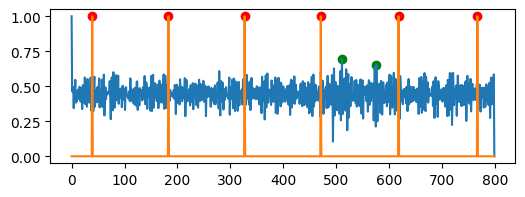

In [38]:
s = np.argsort(losses_anchor)
selected = s[-10]
print(selected, losses_anchor[selected])
plt.figure(figsize=(6, 2))
plt.plot(norm_ecg(Anchor_pred[selected]), label='pred')
plt.style.use('default')
plt.plot(norm_ecg(Anchor_gts[selected]), label='gts')
print(sparseness(norm_ecg(Anchor_pred[selected])))
print(mean_squared_error(norm_ecg(Anchor_gts[selected]), norm_ecg(Anchor_pred[selected])))
peaks_gts = find_peaks(norm_ecg(Anchor_gts[selected]), distance=30)[0]
peaks_pred = find_peaks(norm_ecg(Anchor_pred[selected]), distance=60, prominence=0.4)[0]
plt.scatter(peaks_gts, norm_ecg(Anchor_gts[selected])[peaks_gts], c='r')
plt.scatter(peaks_pred, norm_ecg(Anchor_pred[selected])[peaks_pred], c='g')


38 0.0038146316073834896
0.8685302698372436 0.0038146316073834896


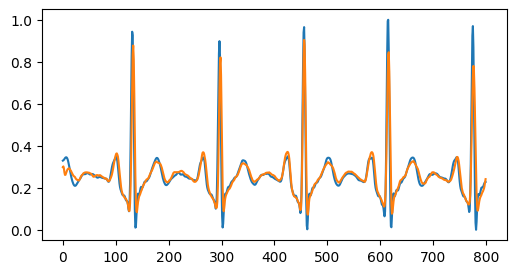

In [39]:
s = np.argsort(losses_mse)
selected = s[10]
print(selected, losses_mse[selected])
plt.figure(figsize=(6, 3))
pred_plot = (ECG_pred[selected])
plt.plot(norm_ecg(ECG_gts[selected,:]), label='gts')
plt.plot((pred_plot), label='pred')
np.save("fs_good.npy", norm_ecg(pred_plot))
pcc = np.corrcoef(pred_plot, norm_ecg(ECG_gts[selected,:]))[0,1]
rmse = (mean_squared_error((pred_plot), norm_ecg(ECG_gts[selected,:])))
print(pcc, rmse)

np.int64(38)

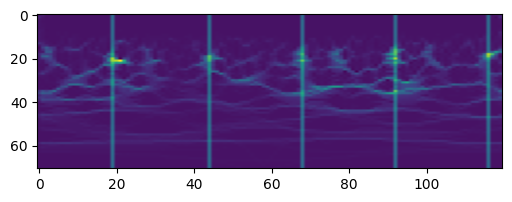

In [40]:
# selected = 4
sst = Inputs[selected][0].detach().cpu().numpy().astype(float)
# peak in anchor
one_indice = np.where(Anchor_gts[selected]>0.4)[0]

for idx in one_indice:
    ii = int(idx/200*30)
    sst[:,:,ii] += 0.3
plt.figure(figsize=(6, 2))
plt.imshow(sst[0], aspect='auto')
selected